<a href="https://colab.research.google.com/github/hungngo97/Sparse-Regression/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Conceptual Resources and mathematical materials
[KL Divergence](https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/)

[AIC Criteria](https://en.wikipedia.org/wiki/Akaike_information_criterion)

[BIC Criteria]( https://en.wikipedia.org/wiki/Bayesian_information_criterion)

[BZ Chemical Reaction Oscillator](https://scipython.com/blog/simulating-the-belousov-zhabotinsky-reaction/)



# Section 1: Reading data set concerning Canadian lynx and snowshoe hare populations from 1845 to 1903.
The given data is in .mat file so it is more complicated to read data from
#1.1: Google Auth Permission to Access Google Drive


In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 9.7MB/s 


In [0]:
filenames = ['BZ.mat', 'population.mat']
links = ['https://drive.google.com/open?id=1MT9PgT8iItCGyD3zUgcG3kLjDaAp2Wnw',
         'https://drive.google.com/open?id=1r9Hg_rwMie2tC8UuqE3gAURABFPkn-VZ']
for index, filename in enumerate(filenames):
  _, id = links[index].split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)

1MT9PgT8iItCGyD3zUgcG3kLjDaAp2Wnw
1r9Hg_rwMie2tC8UuqE3gAURABFPkn-VZ


In [0]:
!pip install hdf5storage
import hdf5storage
mat = hdf5storage.loadmat(filenames[0])

     |████████████████████████████████| 61kB 7.3MB/s 


In [0]:
BZ_tensor = mat['BZ_tensor']
# Shape = (351, 451, 1200)

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
m,n,k=BZ_tensor.shape # x vs y vs time data

#m by n is too big, therefore we can try to crop it
row_start = 150
row_end = 200
column_start = 200
column_end = 250
def plot_timestep(timestep):  
  A=BZ_tensor[:,:,timestep]
  plt.imshow(A)
  plt.colorbar(orientation="horizontal", pad=0.2)
def plot_timestep_cropped(timestep):  
  A=BZ_tensor[row_start: row_end,column_start:column_end,timestep]
  plt.imshow(A)
  plt.colorbar(orientation="horizontal", pad=0.2)

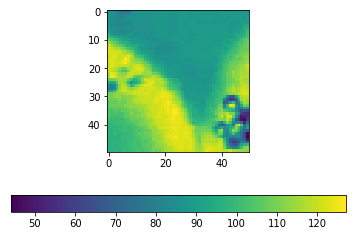

In [0]:
plot_timestep_cropped(200)

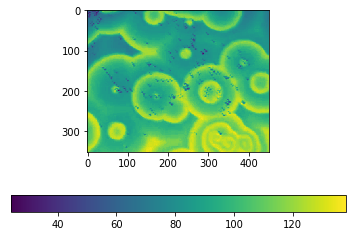

In [0]:
plot_timestep(200)

Continuous frames illustrates the dynamics of the chemical substances in this reaction.
In this problem, we are given video frames describing the dynamics of a Belousov-Zhabotinsky chemical oscillator movie, which we would want to potentially extract out equations that describing the movement of chemical substances on the frames. Our first approach is to perform basic image processing techniques: stacking each pixels rows of the image to create a long column vector representing one frame and horizontally stack each column to create one big 


In [0]:
X = None
k = 100
# row_start = 0
# row_end = m
# colummn_start = 0
# column_end = n


for t in range(k):
  X_t = BZ_tensor[row_start: row_end,column_start:column_end,t]
  x = np.zeros((1,n))
  for i in range(row_end - row_start):
    x = np.concatenate((x, X_t[i,:]),axis=None)
  if X is None:
    X = x
  else:
    X = np.vstack((X, x))

Text(0, 0.5, 'Magnitude')

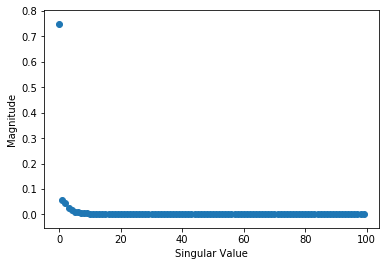

In [0]:

X = np.transpose(X)
[u,s,v]= np.linalg.svd(X, full_matrices=False)
plt.scatter(range(s.shape[0]), s/(np.sum(np.diag(s))))
plt.xlabel('Singular Value')
plt.ylabel('Magnitude')

Since it is not really a confident way to continue processing the data with the projected data by using singular value decomposition, this approach decides to focus on just a 50 by 50 image frame in the center of the image as input and from there perform similar regression framework described in section 3.1 to extract equation from the dynamical system with library function as follows:
 = [x, x, x2, x' , x * x', x2 * x', x3, x3 * x'  

In [0]:
dt= 1;
m,n = X.shape; 

Xdot = np.zeros((m, n - 2))
for jj in range(m):
  for j in range(1, n - 1):
    Xdot[jj, j - 1] = (X[jj, j + 1] - X[jj, j - 1]) / (2 * dt)




In [0]:
# Derivative matrix
dx = np.add(np.subtract(X[:,0], X[:, 1]), 1e-1)
dx = dx.reshape((-1, 1))
# % derv matrices
# dx=x(2)-x(1);

D = np.zeros((m, m)) # m by m is too big 
D2 = np.zeros((m, m))

for j in range(m - 1):
  D[j, j + 1] = 1
  D[j + 1, j] = -1
  D2[j, j + 1] = 1
  D2[j + 1, j] = 1
  D2[j, j] = -2


In [0]:
D[m - 1, 0] = 1
D[0, m - 1] = -1
D = (1 / (2 * dx)) * D
D2[m - 1, m - 1] = -2
D2[m - 1, 0] = 1
D2[0, m - 1] = 1
D2 = D2 / (np.power(dx, 2))


In [0]:
u = np.reshape( np.transpose(X[:, 1:n -1]), ((n - 2) * m, 1))
# u=reshape( X(:,2:end-1).',(n-2)*m ,1 );

ux = np.zeros((n - 2, m))
uxx = np.zeros((n - 2, m))
u2x = np.zeros((n - 2, m))
for jj in range(1, n - 1):
  currentState = np.reshape(X[:, jj], (-1, 1))
  ux[jj - 1, :] = (np.transpose((np.matmul(D,currentState))))
  uxx[jj - 1, :] = (np.transpose(np.matmul(D2, currentState)))
  uxx[jj - 1, :] = (np.transpose(np.matmul(D,(np.power(currentState, 2)))))

ux = np.reshape(ux, ((n - 2 * m) , 1))
uxx = np.reshape(uxx, ((n - 2 * m) , 1))
u2x = np.reshape(u2x, ((n - 2 * m) , 1))

# A=[u u.^2 u.^3 Ux Uxx U2x Ux.*u Ux.*Ux Ux.*Uxx];
u2 = np.power(u,2)
u3 = np.power(u,3)
u4 = np.power(u, 4)
ux2 = np.power(ux, 2)
ux3 = np.power(ux, 3)
uux = np.multiply(ux, u)
uxux = np.multiply(ux,ux)
uxuxx = np.multiply(ux, uxx)
A = np.array([u, u2, u3, u4, ux, ux2, ux3,  uxx, u2x, uux, uxux, uxuxx])[:,:,0]
library = A.shape[1]
Udot = np.reshape(np.transpose(Xdot), ((n - 2) * m, 1))


In [0]:
from sklearn import linear_model

# A x = b
# b = (289198,1)
# A = (9, 289198)
# (289198, 9) * (9, 1) = (289198, 1)
#Lasso
A = np.transpose(A)
clf_lasso_BZ = linear_model.Lasso(alpha=0.5)
clf_lasso_BZ.fit(A[()], Udot)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Text(0, 0.5, "Coefficient Magnitude (U')")

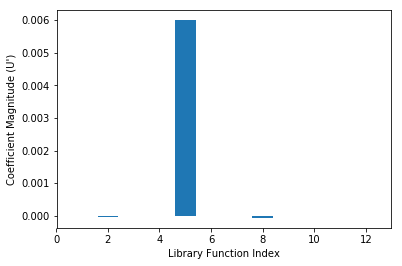

In [0]:
plt.bar(range(1, 12 + 1), clf_lasso_BZ.coef_)
plt.xlabel('Library Function Index')
plt.ylabel("Coefficient Magnitude (U')")

# Part 1: Predator-Prey Model
In this section, we are given the data concerning the time series describing the population of 2 species from 1845 to 1903 and we desire to find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [0]:
from scipy.io import loadmat

data = loadmat('population.mat')

In [0]:
x1 = data['hare']
x2 = data['lynx']
t = data['year']
dt=2
x0=[x1[0] , x2[0]]

Since the data space is too small to fit a Lasso regression, which might lead to overfitting the data, we need to augment more data by interpolating new data from existing data points using a curve fit interpolation from Scipy

Text(0, 0.5, 'Thousands')

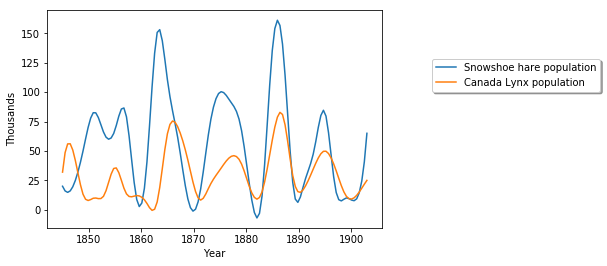

In [0]:
from scipy.interpolate import interp1d
f_hare = interp1d(t.squeeze(), x1.squeeze(), kind='cubic')
f_lynx = interp1d(t.squeeze(), x2.squeeze(), kind='cubic')
t = np.linspace(1845, 1903, num=120, endpoint=True)
x1 = f_hare(t)
x2 = f_lynx(t)
x1 = np.reshape(x1,(-1, 1))
x2 = np.reshape(x2, (-1, 1))
plt.plot(t,x1,t,x2)
plt.gca().legend(('Snowshoe hare population','Canada Lynx population'),
                loc='upper center', bbox_to_anchor=(1.4, 0.8), shadow=True, ncol=1)
plt.xlabel('Year')
plt.ylabel('Thousands')

Text(0, 0.5, 'Canada Lynx population (thousands)')

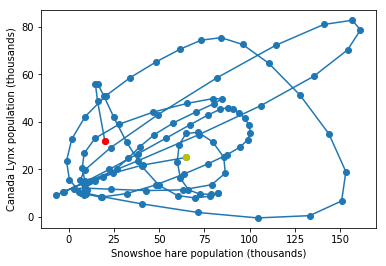

In [0]:
plt.plot(x1, x2, '-o', x1[0], x2[0], 'ro', x1[x1.shape[0] - 1], x2[x2.shape[0] - 1 ], 'yo')
plt.xlabel('Snowshoe hare population (thousands)')
plt.ylabel('Canada Lynx population (thousands)')

Dynamics of the system describing the relationship and interaction between 2 species with the red point describing the initial population state in 1850 and yellow point describing the population state in 1900. There seems to be equations governing the interactions between the 2 species since it establishes some kind of periodic and circular movement.
We first calculates the derivative of each variable using a central difference scheme from scientific computing equations. Next, we create a library functions that may establish similar interaction between species. Now this is where we can get creative with the library function since it literally can be any equation and then Lasso regression will later verify if the equations match with the data. In this paper, since we know this problem is more similar to the popular differential equation model of predator-prey system, we propose the following library function:
 = [x1, x2, x12,x1 * x2, x22, x13, x23 ]
 
 where x1 represents Snowshoe hare population and x2 represents Canada Lynx population. Eventually, we can just apply Lasso regression with our library function and the derivative of each variable and examine the coefficients.

In [0]:
n= t.size
x1dot = np.zeros((n-2,1))
x2dot = np.zeros((n-2,1))
for j in range(1,n-1):
  x1dot[j-1]=(x1[j+1]-x1[j-1])/(2*dt)
  x2dot[j-1]=(x2[j+1]-x2[j-1])/(2*dt)

x1s=x1[1:n-1]
x2s=x2[1:n-1]
A=np.array([x1s, x2s, np.power(x1s,2), np.multiply(x1s,x2s), np.power(x2s,2),
            np.power(x1s,3), np.multiply(np.power(x2s,2), np.power(x1s,2)), 
            np.power(x2s,3)])[:,:,0]
A = np.transpose(A)


In [0]:
from sklearn import linear_model

# A x = b
# b = (28,1)
# A = (8, 28)
# (8, 28) *    (8, 1)   = (28,1)
#Lasso
clf_lasso_x1 = linear_model.Lasso(alpha=0.5)
clf_lasso_x1.fit(A[()], x1dot)

clf_lasso_x1_2 = linear_model.Lasso(alpha=0.1)
clf_lasso_x1_2.fit(A[()], x1dot)

clf_lasso_x1_3 = linear_model.Lasso(alpha=0.3)
clf_lasso_x1_3.fit(A[()], x1dot)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Text(0, 0.5, "Coefficient Magnitude (x1')")

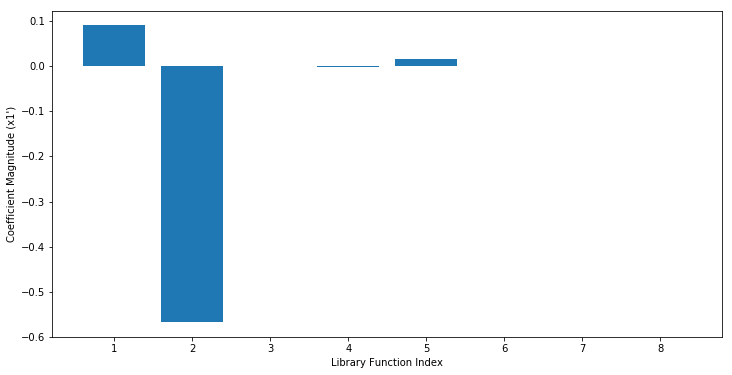

In [0]:
# fig=plt.figure(figsize=(12, 6))
# plt.bar(range(8), clf_lasso_x1.coef_)
fig=plt.figure(figsize=(12, 6))
plt.bar(range(1,8 + 1), clf_lasso_x1_2.coef_)
plt.xlabel('Library Function Index')
plt.ylabel("Coefficient Magnitude (x1')")
# fig=plt.figure(figsize=(12, 6))
# plt.bar(range(8), clf_lasso_x1_3.coef_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0, 0.5, "Coefficient Magnitude (x2')")

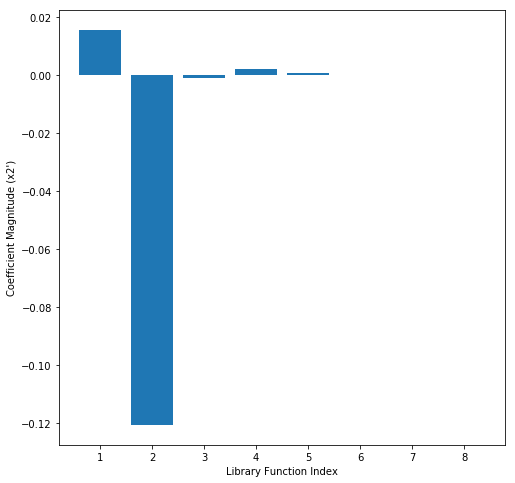

In [0]:
clf_lasso_x2 = linear_model.Lasso(alpha=0.5)
clf_lasso_x2.fit(A[()], x2dot)

clf_lasso_x2_2 = linear_model.Lasso(alpha=0.1)
clf_lasso_x2_2.fit(A[()], x2dot)

clf_lasso_x2_3 = linear_model.Lasso(alpha=0.3)
clf_lasso_x2_3.fit(A[()], x2dot)
# fig=plt.figure(figsize=(8, 8))
# plt.bar(range(8), clf_lasso_x2.coef_)
fig=plt.figure(figsize=(8, 8))
plt.bar(range(1, 1+ 8), clf_lasso_x2_2.coef_)
plt.xlabel('Library Function Index')
plt.ylabel("Coefficient Magnitude (x2')")
# fig=plt.figure(figsize=(8, 8))
# plt.bar(range(8), clf_lasso_x2_3.coef_)

In [0]:
coefficients = clf_lasso_x1.coef_.argsort()[-3:][::-1] #Get index of top 3 values
coefficients_x2_2 = clf_lasso_x1_2.coef_.argsort()[-3:][::-1] #Get index of top 3 values
coefficients_x2_3 = clf_lasso_x1_3.coef_.argsort()[-3:][::-1]
y_predicted = np.zeros((118, 1))
scale = 1 #Original scale = 1, got the same shape but might be better if we add
# more scale in
for index in coefficients:
  print(index)
  y_predicted_3 = np.add(y_predicted, np.reshape(A[:, index]* scale * clf_lasso_x1_3.coef_[index], (-1, 1)))
  y_predicted_2 = np.add(y_predicted, np.reshape(A[:, index]* scale * clf_lasso_x1_2.coef_[index], (-1, 1)))
  y_predicted = np.add(y_predicted, np.reshape(A[:, index]* scale * clf_lasso_x1.coef_[index], (-1, 1)))
  y_predicted_scaled = np.add(y_predicted, np.reshape(A[:, index]* 2 * clf_lasso_x1.coef_[index], (-1, 1)))


0
4
5


Text(0, 0.5, 'Snowshoe Hare population (thousands)')

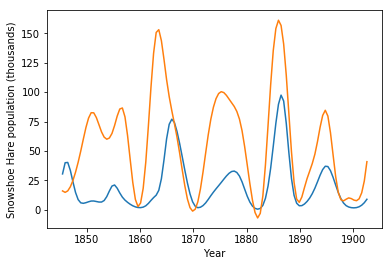

In [0]:
plt.plot(t[1:120-1], y_predicted, t[1:120-1], x1[1:120-1])
plt.xlabel('Year')
plt.ylabel('Snowshoe Hare population (thousands)')
# plt.gca().legend(('Predicted','Actual'),
#                 loc='upper center', bbox_to_anchor=(1.4, 0.8), shadow=True, ncol=1)

0
3
7


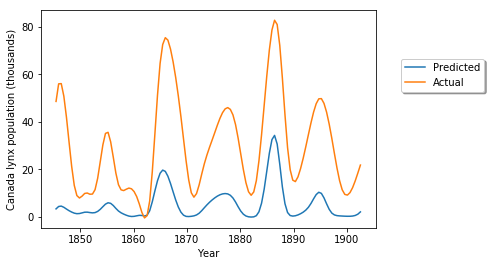

In [0]:
coefficients2 = clf_lasso_x2.coef_.argsort()[-3:][::-1] #Get index of top 3 values
y_predicted2 = np.zeros((118, 1))
scale = 1
for index in coefficients2:
  print(index)
  y_predicted2 = np.add(y_predicted2, np.reshape(A[:, index]*  scale * clf_lasso_x2.coef_[index], (-1, 1)))
  y_predicted2_3 = np.add(y_predicted2, np.reshape(A[:, index]* scale * clf_lasso_x2_3.coef_[index], (-1, 1)))
  y_predicted2_2 = np.add(y_predicted2, np.reshape(A[:, index]* scale * clf_lasso_x2_2.coef_[index], (-1, 1)))
  y_predicted2_scaled = np.add(y_predicted2, np.reshape(A[:, index]* 2 * clf_lasso_x2.coef_[index], (-1, 1)))
plt.plot(t[1:120-1], y_predicted2, t[1:120-1], x2[1:120-1])
plt.xlabel('Year')
plt.ylabel('Canada lynx population (thousands)')
plt.gca().legend(('Predicted','Actual'),
                loc='upper center', bbox_to_anchor=(1.2 , 0.8), shadow=True, ncol=1)


Predicted time series describing species population using the mathematical equations proposed by Lasso sparse regression. Although the model cannot predict well to the actual value, it is interesting to note that the model is able to capture the shape and movement of each species through time and the model can be further modified by scaling the model with a constant.

In [0]:
# x1edges = np.linspace(0,160,3);
# x2edges = np.linspace(0,85,3);
from scipy import stats
x1edges = np.array([0, 40, 80, 120, 160])
x2edges = np.array([0, 20, 40, 60, 80])
dx1edges = x1edges[1] - x1edges[0]
dx2edges = x2edges[1] - x2edges[0]
H1, xedges, yedges = np.histogram2d(x1.flatten(), x2.flatten(), bins=(x1edges, x2edges))

H_predicted, _, _ = np.histogram2d(y_predicted.flatten(), y_predicted2.flatten(), bins=(x1edges, x2edges))
H_predicted_2, xedges1, yedges1 = np.histogram2d(y_predicted_2.flatten(), y_predicted2_2.flatten(), bins=(x1edges, x2edges))
H_predicted_3, _, _ = np.histogram2d(y_predicted_3.flatten(), y_predicted2_3.flatten(), bins=(x1edges, x2edges))
H_predicted_scaled, _, _ = np.histogram2d(y_predicted_scaled.flatten(), y_predicted2_scaled.flatten(), bins=(x1edges, x2edges))

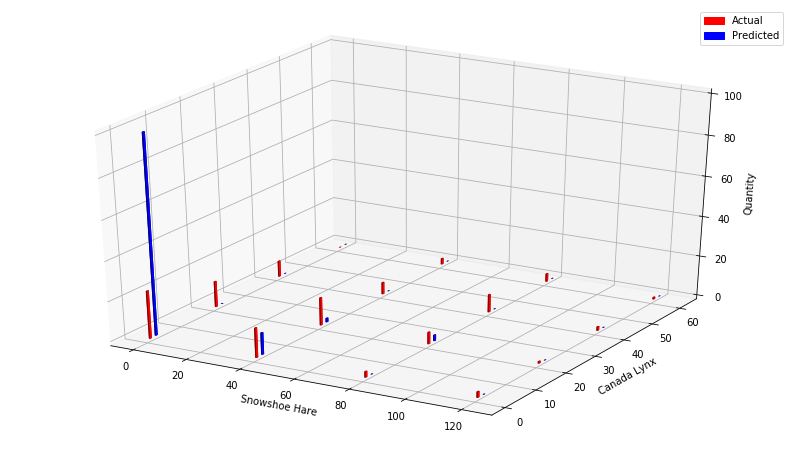

In [0]:
import matplotlib.patches as mpatches
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

xpos1, ypos1 = np.meshgrid(xedges1[:-1] + 0.25, yedges1[:-1] + 0.25, indexing="ij")
xpos1 = xpos1.ravel()
ypos1 = ypos1.ravel()
zpos1 = 0


fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = H1.ravel()

dx1 = dy1 = 0.5 * np.ones_like(zpos1)
dz1 = H_predicted.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')
ax.bar3d(xpos1 + 1, ypos1 + 1, zpos1 + 1, dx1, dy1, dz1, color='b', zsort='average')
ax.set_xlabel('Snowshoe Hare')
ax.set_ylabel('Canada Lynx')
ax.set_zlabel('Quantity')

handles = [mpatches.Patch(color='red'),
          mpatches.Patch(color='blue')]
labels= ["Actual","Predicted"]
plt.legend(handles, labels)

plt.show()


In [0]:
print (stats.entropy(pk=H_predicted, qk=H1))
print (stats.entropy(pk=H_predicted_2, qk=H1))
print (stats.entropy(pk=H_predicted_3, qk=H1))
print (stats.entropy(pk=H_predicted_scaled, qk=H1))
print("SUM")
print (sum(stats.entropy(pk=H_predicted, qk=H1)))
print (sum(stats.entropy(pk=H_predicted_2, qk=H1)))
print (sum(stats.entropy(pk=H_predicted_3, qk=H1)))
print (sum(stats.entropy(pk=H_predicted_scaled, qk=H1)))

[0.5696225  0.51354758 1.42711636 0.98082925]
[0.52819354 0.51354758 1.42711636 0.14384104]
[0.5696225  0.51354758 1.42711636 0.98082925]
[0.56905699 0.61711457 1.42711636 0.98082925]
SUM
3.4911156960053296
2.6126985197677777
3.4911156960053296
3.5941171692881086


In [0]:

# AIC, BIC calculation
AICs = []
BICs = []
predictions = [(y_predicted, y_predicted2), 
               (y_predicted_2, y_predicted2_2),
                (y_predicted_3, y_predicted2_3), 
                 (y_predicted_scaled, y_predicted2_scaled)]
for predictionx1, predictionx2 in predictions:
  resid = x1[1:120-1] - predictionx1
  resid += x2[1:120-1] - predictionx2
  sse = sum(resid**2)
  k= 3
  AIC= 2*k - 2*np.log((sse))
  AICs.append(AIC)
  n = 118
  BIC = n*np.log(sse/n) + k*np.log(n)
  BICs.append(BIC)
print(AICs)
print(BICs)

[array([-19.70764716]), array([-19.75747808]), array([-19.65151934]), array([-19.59191531])]
[array([968.1224508]), array([971.06247488]), array([964.81090922]), array([961.29427127])]


In [0]:
import math
minAIC = min(AICs)
deltaAICs = [aic - minAIC for aic in AICs]
sumDeltaAICs = 0
for deltaAIC in deltaAICs:
  sumDeltaAICs += math.exp(-0.5 * deltaAIC)
aikaikeWeights = [math.exp(-0.5 * deltaAic) / sumDeltaAICs for deltaAic in deltaAICs]

minBIC = min(BICs)
deltaBICs = [bic - minBIC for bic in BICs]
sumDeltaBICs = 0
for deltaBIC in deltaBICs:
  sumDeltaBICs += math.exp(-0.5 * deltaBIC)
bayesianWeights = [math.exp(-0.5 * deltaBic) / sumDeltaBICs for deltaBic in deltaBICs]

print(aikaikeWeights)
print(bayesianWeights)

[0.2537213863164965, 0.26012238168748447, 0.2466999569548378, 0.2394562750411813]
[0.027132393685014227, 0.006238353653106199, 0.14209546791994165, 0.8245337847419378]


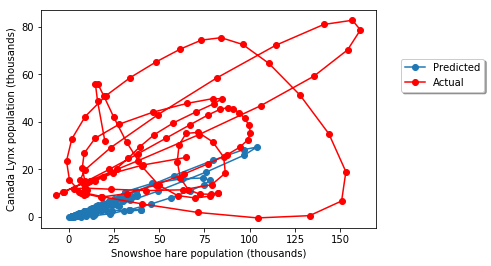

In [0]:
plt.plot(y_predicted_2, y_predicted2_2, '-o', x1, x2, '-ro')
plt.xlabel('Snowshoe hare population (thousands)')
plt.ylabel('Canada Lynx population (thousands)')
plt.gca().legend(('Predicted','Actual'),
                loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

#Perform Time-Delayed Embeddings

Text(0, 0.5, 'Magnitude')

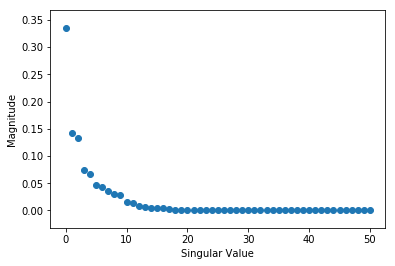

In [0]:
# H=[x1[0:110],
#    x1[1:111],
#    x1[2:112],
#    x1[3:113],
#    x1[4:114],
#    x1[5:115],
#    x1[6:116],
#    x1[7:117]];

def build_hankel_matrix(x, layers):
  size = x.shape[0]
  H = np.zeros((1, size - layers)) #(1, 107)
#   print("From \t To")
  for i in range(layers):
#     print(str(i) + "\t " + str(size - layers + i))
    H = np.vstack((H, np.transpose(x1[i : size - layers + i])))
  return H

def build_hankel_matrix_2vars(x1, x2, layers):
  size = x1.shape[0]
  H = np.zeros((1, size - layers)) #(1, 107)
#   print("From \t To")
  for i in range(layers):
#     print(str(i) + "\t " + str(size - layers + i))
    H = np.vstack((H, np.transpose(x1[i : size - layers + i])))
    H = np.vstack((H, np.transpose(x2[i : size - layers + i])))
  return H



layers = 50
H = build_hankel_matrix(x1, layers)
[u,s,v]= np.linalg.svd(H)
plt.scatter(range(layers + 1), s/(np.sum(np.diag(s))))

# H2 = build_hankel_matrix(x2, layers)
# [u,s,v]= np.linalg.svd(H2)
# plt.scatter(range(layers + 1), s/(np.sum(np.diag(s))))

# H_2vars = build_hankel_matrix_2vars(x1, x2, layers)
# [u,s,v]= np.linalg.svd(H_2vars)
# plt.scatter(range(s.shape[0]), s/(np.sum(np.diag(s))))
plt.xlabel('Singular Value')
plt.ylabel('Magnitude')



# figure(6), plot(300*v(:,4),'Linewidth',[2])
# hold on
# plot(x(1:5000))

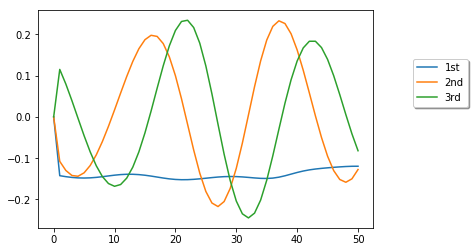

In [0]:
plt.plot(u[:,0:3])
plt.gca().legend(('1st','2nd', '3rd'),
                loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

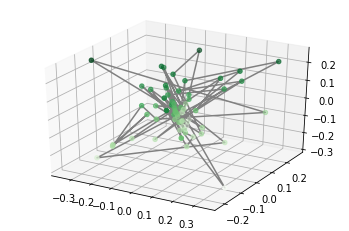

In [0]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
# plt.plot3(v[:,1],v[:,2],v[:,3])
ax.plot3D(v[:,1],v[:,2],v[:,3], 'gray')
ax.scatter3D(v[:,1],v[:,2],v[:,3], c=v[:,3], cmap='Greens');